In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [2]:
data = pd.read_csv('carInsurance_train.csv')

data.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
Id                  4000 non-null int64
Age                 4000 non-null int64
Job                 3981 non-null object
Marital             4000 non-null object
Education           3831 non-null object
Default             4000 non-null int64
Balance             4000 non-null int64
HHInsurance         4000 non-null int64
CarLoan             4000 non-null int64
Communication       3098 non-null object
LastContactDay      4000 non-null int64
LastContactMonth    4000 non-null object
NoOfContacts        4000 non-null int64
DaysPassed          4000 non-null int64
PrevAttempts        4000 non-null int64
Outcome             958 non-null object
CallStart           4000 non-null object
CallEnd             4000 non-null object
CarInsurance        4000 non-null int64
dtypes: int64(11), object(8)
memory usage: 593.9+ KB


From the quick information from the data, we can see that there is huge number of missing values (~75%) for <b> Outcome </b>, so we can drop that out from our analysis.
We can also see the less number of missing values for <b>'Job' , 'Education' </b> columns, so we replace it by mode value.<br>
For <b>'Communication'</b>, as there is ~25% of data is missing, we can create new label 'None' for those records.

Also we can see that, there is CallStart & CallEnd time, so it would good to calculate CallDuration for them to utilize it.

In [4]:
data.drop('Outcome', inplace = True, axis=1)

data.Job = data.Job.fillna(data.Job.mode()[0])
data.Education = data.Education.fillna(data.Education.mode()[0])
data.Communication = data.Communication.fillna('None')

data['CallDuration'] = (data.CallEnd.astype('datetime64[ns]') - data.CallStart.astype('datetime64[ns]'))
data['CallDuration']= data['CallDuration'].dt.components['minutes']*60 + data['CallDuration'].dt.components['seconds']


In [5]:
data.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance,CallDuration
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000,350.844000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162,342.236576
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,5.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000,126.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000,232.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000,460.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000,3253.000000


Here we can see the statistics for various integers field. Below are the quick interpretations for few significant columns - 

### Categorical Features
* <b> Default </b>: Around 1.5 % of population are defaulters. <br>
* <b> HHInsurance </b>: Around 49% of population has household insured. <br>
* <b> CarLoan </b>: Around 13% of population has the carloan.<br>
* <b> CarInsurance </b>: Around 40% of population has opted for the insurance. This also represents that there is slight imbalance in the data. <br>

### Numerical Features
* <b> Age </b>: Around 75% of population is below 49 years.<br>
* <b> Balance </b>: Around 50% of population has yearly balance of 551 or less. So there is huge disparity, which would be good to create the range feature for it.<br>
* <b> NoOfContacts </b>: Around 25% of population is contacted more than thrice during the campaign.<br>
* <b> DaysPassed </b>:Around 75% members of population are the new one and were never contacted in past campaigns.


As there are various features, I have seggregated the exploratory analysis into three groups.
* Demographic Analysis
* Insurance & Funds Analysis
* Communication Analysis

### Demographic Analysis

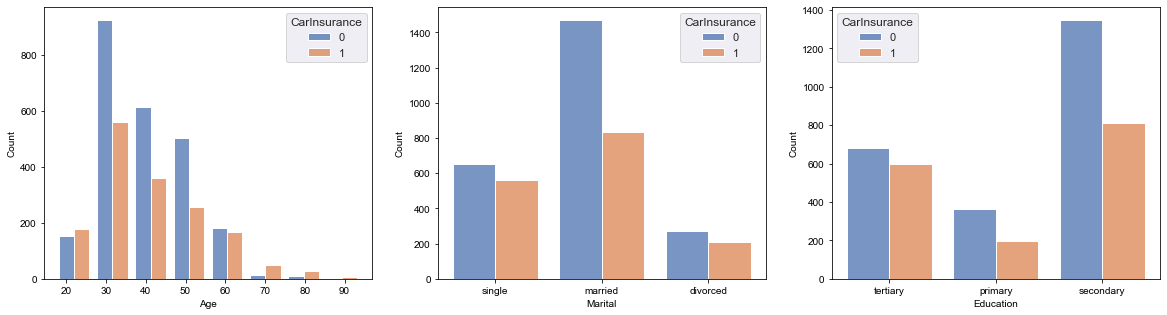

In [6]:
fig, axes = plt.subplots(1, 3, figsize = (20,5))
sns.set_theme(style="darkgrid")

sns.histplot(data, x = "Age", hue = "CarInsurance", multiple = "dodge", shrink = .8, ax = axes[0],bins = 8)
sns.histplot(data, x = "Marital", hue = "CarInsurance", multiple = "dodge", shrink = .8, ax = axes[1])
sns.histplot(data, x = "Education", hue = "CarInsurance", multiple = "dodge", shrink = .8, ax = axes[2])

Here we can interpret as below

* People from younger age group (<25) older age group (>60) are mostly considering for CarInsurance
* Although there are more married people in our data set, but call conversion rate for single & divorced people are higher.
* Call success rate for people with tertiary education is higher as compared to others.

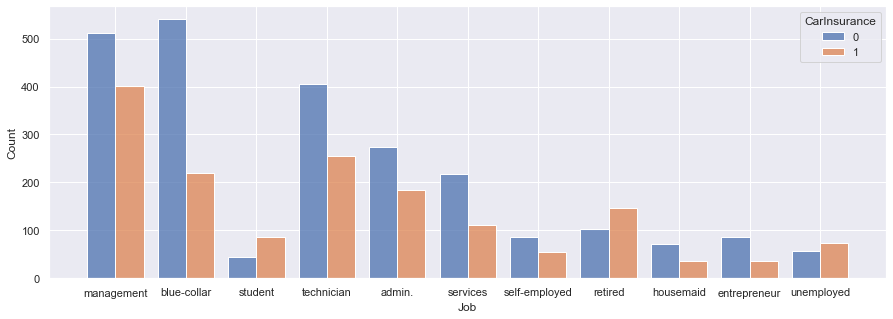

In [7]:
fig, axes = plt.subplots(figsize = (15,5))
sns.histplot(data, x = "Job", hue = "CarInsurance", multiple = "dodge", shrink = .8)

Here we can interpret that, <b>student, retired & unemployed </b>people are more inclined toward having the CarInsurance. Although counts are less, but can also mean that people with unstable income mostly like to have CarInsurance.

### Insurance & Funds Analysis

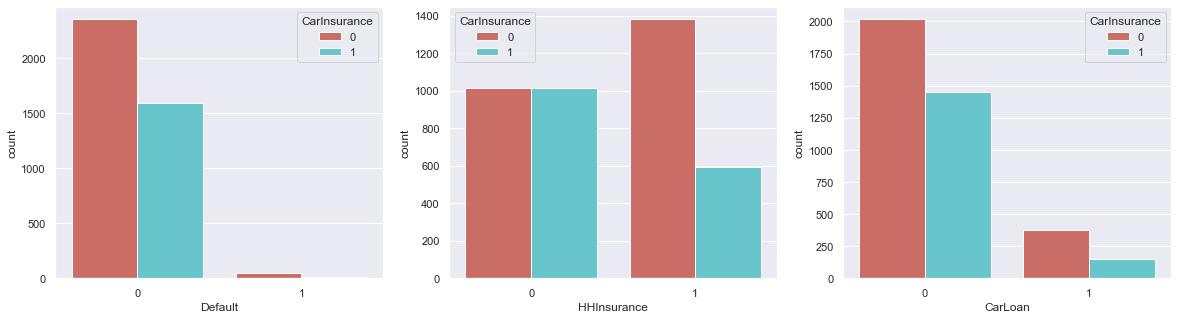

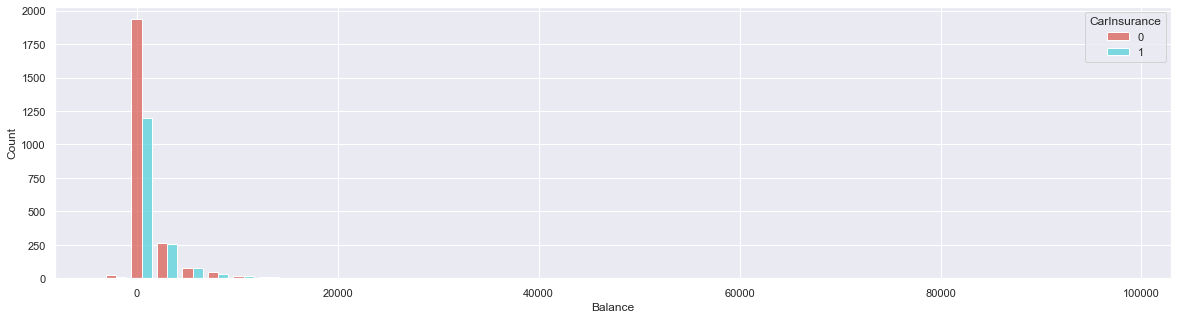

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (20,5))

sns.countplot(data = data, x = "Default", hue = "CarInsurance", ax = axes[0], palette="hls")
sns.countplot(data = data, x = "HHInsurance", hue = "CarInsurance", ax = axes[1], palette="hls")
sns.countplot(data = data, x = "CarLoan", hue = "CarInsurance", ax = axes[2], palette="hls")

fig, axes = plt.subplots(figsize = (20,5))
sns.histplot(data, x = "Balance", hue = "CarInsurance", multiple = "dodge", shrink = .8, bins = 40, palette="hls")

* Defaulters are less likely to be called and opted for the CarInsurance.
* People with household insurance are less likely to go for CarInsurance.
* There are less number of people having CarLoan and they are less likely to have CarInsurance.
* People with higher average yearly balance is more likely to have CarInsurance.

### Communication Analysis

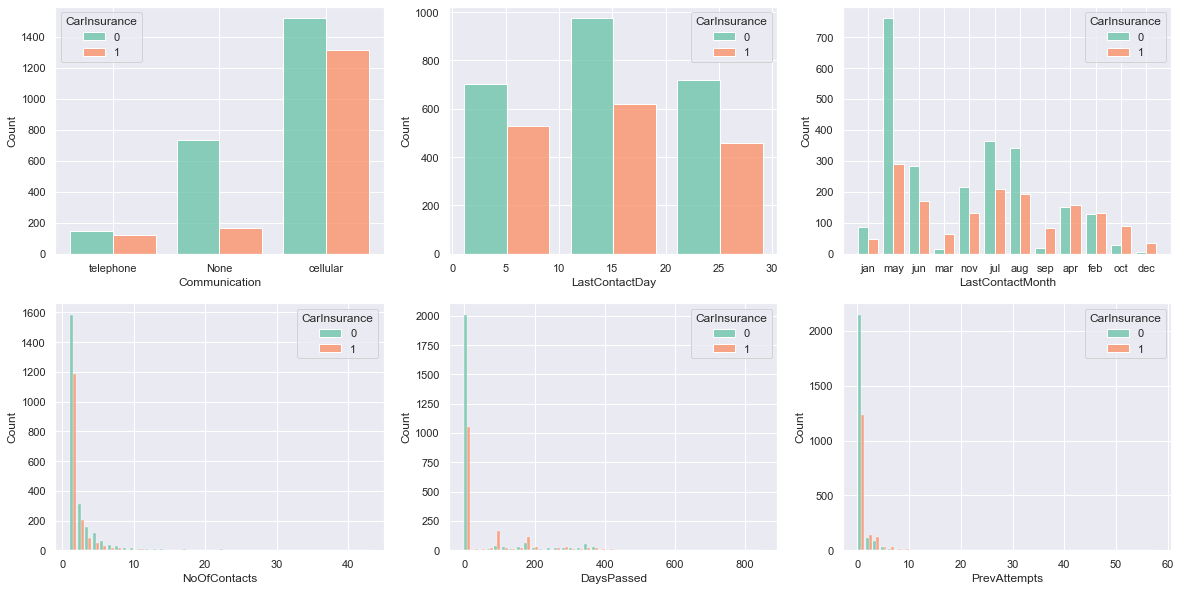

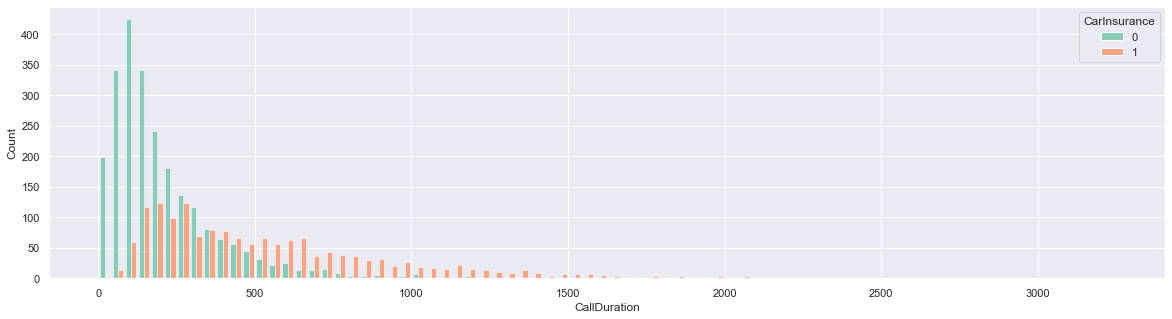

In [9]:
fig, axes = plt.subplots(2, 3, figsize = (20,10))

sns.histplot(data, x = "Communication", hue = "CarInsurance", multiple = "dodge", shrink = .8, palette="Set2", ax = axes[0][0])
sns.histplot(data, x = "LastContactDay", hue = "CarInsurance", multiple = "dodge", shrink = .8, bins = 3, palette="Set2", ax = axes[0][1])
sns.histplot(data, x = "LastContactMonth", hue = "CarInsurance", multiple = "dodge", shrink = .8,  palette="Set2", ax = axes[0][2])
sns.histplot(data, x = "NoOfContacts", hue = "CarInsurance", multiple = "dodge", shrink = .8, bins = 40, palette="Set2", ax = axes[1][0])
sns.histplot(data, x = "DaysPassed", hue = "CarInsurance", multiple = "dodge", shrink = .8, bins = 40, palette="Set2", ax = axes[1][1])
sns.histplot(data, x = "PrevAttempts", hue = "CarInsurance", multiple = "dodge", shrink = .8, bins = 40, palette="Set2", ax = axes[1][2])

fig, axes = plt.subplots(figsize = (20,5))

sns.histplot(data, x = "CallDuration", hue = "CarInsurance", multiple = "dodge", shrink = .8, palette="Set2")

* People reached thorugh cell phones are most likely to have CarInsurance.
* Overall, most people are approached mid of the month (i.e. 10-20 Day)
* During the start & end months of the year has the higher call conversion rate with few exception. That means team should reach out to more customers at that time for having higher success rate.
* For NoOfContacts, DayPassed & PrevAttempts : As the number of count increased, it is high for a call to be successfull.
* As the CallDuration is increased, call conversion rate is higher. That also means, customers are showing interest in the policy once the team is able to engage them through initial conversation.

As we know from previous stats, that there is 40-60 imbalnce in data. So, in simple terms our vanilla model (without Machine Learning) should have a accuracy of 60%, if we classify records to one class. We can use this as a baseline accuracy.<br>
Now lets see if our Machine Learning models can do better.

We will start with data preperation, where we have removed datetime type of data and get the dummies for text categorical data and removing them, so that everything will be in numerical format. Initially, I'm using the data without feature engineering.

In [10]:
data.drop(['CallStart','CallEnd'], axis = 1, inplace=True)
data = pd.get_dummies(data)

In [11]:
data.head()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,...,LastContactMonth_dec,LastContactMonth_feb,LastContactMonth_jan,LastContactMonth_jul,LastContactMonth_jun,LastContactMonth_mar,LastContactMonth_may,LastContactMonth_nov,LastContactMonth_oct,LastContactMonth_sep
0,1,32,0,1218,1,0,28,2,-1,0,...,0,0,1,0,0,0,0,0,0,0
1,2,32,0,1156,1,0,26,5,-1,0,...,0,0,0,0,0,0,1,0,0,0
2,3,29,0,637,1,0,3,1,119,1,...,0,0,0,0,1,0,0,0,0,0
3,4,25,0,373,1,0,11,2,-1,0,...,0,0,0,0,0,0,1,0,0,0
4,5,30,0,2694,0,0,3,1,-1,0,...,0,0,0,0,1,0,0,0,0,0


###### Preparing the train & test data in 80-20 ratio for training and validation of the model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id','CarInsurance'],axis=1), data.CarInsurance, test_size=0.20, random_state=42)

Now the data is ready, we are good to train ML models. I'm going to use three type of algorithms for the comparison purposes.

* Probability based algorithms
* Distance based algorithms
* Tree & Ensemble based algorithms

##### Probability Based Algorithms

In [13]:
Classifiers = [
    LogisticRegression(),
    GaussianNB()]


for classifier in Classifiers:

    fit = classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,pred)  
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(round(accuracy*100,2)) + '%')

Accuracy of LogisticRegression is 82.62%
Accuracy of GaussianNB is 75.62%


From the above two, Logistic Regression is performing better and both are showing good results than our base line accuracy score (>60%)

##### Distance Based Algorithms

In [14]:
Classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="rbf", C=0.025, probability=True)
    ]


for classifier in Classifiers:

    fit = classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,pred)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(round(accuracy*100,2)) + '%')

Accuracy of KNeighborsClassifier is 77.25%
Accuracy of SVC is 60.5%


KNeighbors Classifier shown slight increment in accuracy than GaussianNB. Now lets try the another type of algorithms. 

##### Tree & Ensemble Based Algorithms

As the data has majority of categorical features, I'm expecting that Tree & Ensemble based approach will perform better.

In [15]:
Classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    XGBClassifier(eval_metric='mlogloss')
    ]


for classifier in Classifiers:

    fit = classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,pred)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(round(accuracy*100,2)) + '%')


Accuracy of DecisionTreeClassifier is 79.38%
Accuracy of RandomForestClassifier is 83.75%
Accuracy of AdaBoostClassifier is 83.25%
Accuracy of XGBClassifier is 84.25%


###### Tree based & Ensemble classifiers are performing better than other algorithms, showing significant improvement in accuracy score.

Now lets see the importance of various variable on predicting the target variable. Here we have considered XG-Boost classifier for features significance analysis.

In [16]:
model = XGBClassifier(eval_metric='mlogloss')

model.fit(X_train,y_train)
pred = model.predict(X_test)
accuracy_score(y_test,pred)

0.8425

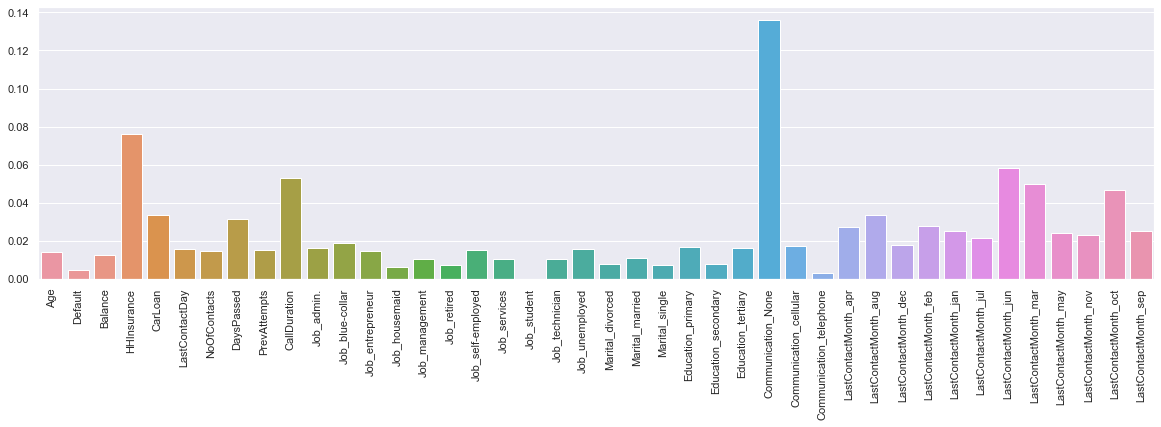

In [17]:
# get importance
importance = model.feature_importances_

fig, axes = plt.subplots(figsize = (20,5))
# plot feature importance
plt.xticks(rotation=90)
sns.barplot([x for x in X_train.columns], importance)
plt.show()


From the above graph, we can see that Communication_None label is showing high significance, followed by HHInsurance, LastContactMonth, CallDuration & so on.

<b>Interesting to note that Age, Balance, PrevAttempts </b>which are continious variable and expected to show the impact from our Exploratory analysis, is not showing any significant contribution in our target variable. Now I will try to tweak the features by binning them to make it in categorical forms.

In [18]:
data['AgeGroup'] = data.Age.apply(lambda x: 'Y' if x < 25 else ('M' if x <60 else 'S'))
#data['BalanceGroup'] = data.Balance.apply(lambda x: 'L' if x < 551 else 'H')
#data['PrevAttemptsGroup'] = data.PrevAttempts.apply(lambda x: 'L' if x<3 else 'H')

data.drop(['Age'], axis=1, inplace=True)

data = pd.get_dummies(data)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id','CarInsurance'],axis=1), data.CarInsurance, test_size=0.20, random_state=42)


model = XGBClassifier(eval_metric='mlogloss')

model.fit(X_train,y_train)
pred = model.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('Accuracy of '+model.__class__.__name__+' is '+str(round(accuracy*100,2)) + '%')


Accuracy of XGBClassifier is 86.12%


Here we can see that, the accuracy score has been improved by 2%. Although I tried to use binning for other continious features as well but only AgeGroup binning has shown the improvement in the result.

Now lets see the importance of various features in this new model

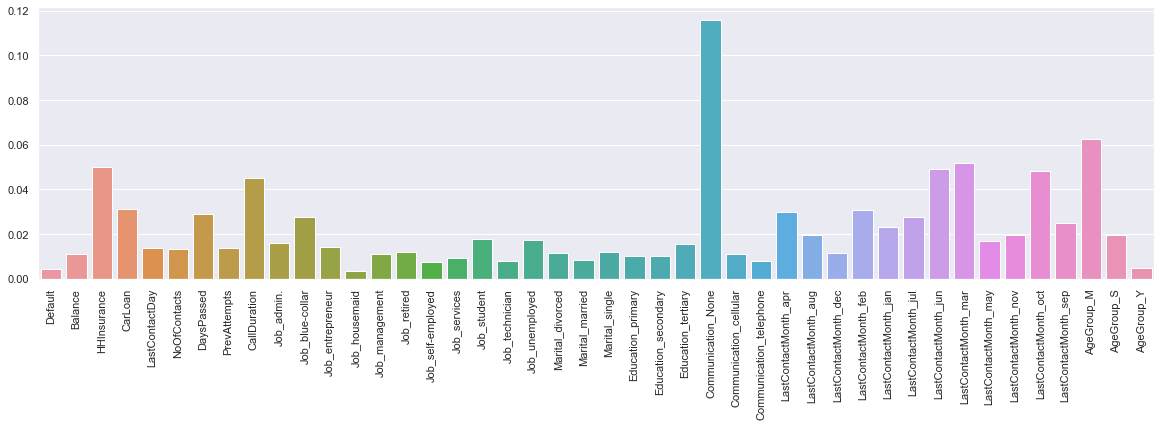

In [20]:
# get importance
importance = model.feature_importances_

fig, axes = plt.subplots(figsize = (20,5))
# plot feature importance
plt.xticks(rotation=90)
sns.barplot([x for x in X_train.columns], importance)
plt.show()

Here we can see that AgeGroup labels are showing increased significance on target variable, which can also be seen in improved model accuracy.

Now we will further evaluate the model

In [21]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       484
           1       0.81      0.85      0.83       316

    accuracy                           0.86       800
   macro avg       0.85      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



From the classification report, we can say that 81% of time the model is precisely predicting the '1' whereas 85% of the time our prediction for '1' is correct.

Now let's see, how well the model is going to perform on all the subsets of data. I have used 10-Fold validation to evaluate the efficiency for future data.

In [22]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# evaluate model
scores = cross_val_score(model, data.drop(['Id','CarInsurance'],axis=1), data.CarInsurance, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f with std of (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.850 with std of (0.015)


And we can see that accuracy for the model is 85% with standard deviation of 0.015